In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
# Configs
class CFG:
    #Random seed
    SEED = 42
    BASE = os.getcwd()
    #Hyperparamets
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 128
    num_epochs = 10
    
    image_size = 32
    auto = tf.data.AUTOTUNE

In [2]:
#Standart libs
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
import numpy as np
import random
import os
from tensorflow.keras import backend as K

def set_seed(seed=42):
    # Set the Python hash seed
    os.environ['PYTHONHASHSEED']=str(seed)
    os.environ['TF_NUM_INTRAOP_THREADS'] = str(seed)
    # Set the Python, Numpy and Tensorflow random seeds
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.compat.v1.set_random_seed(seed)
    # Set deterministic options for Tensorflow
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    # Limit Tensorflow to single thread for full reproducibility
    tf.config.threading.set_inter_op_parallelism_threads(1)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    print('seeding done!!!')
set_seed(CFG.SEED)


seeding done!!!


In [4]:
import tensorflow_addons as tfa

# Load the CIFAR-10 dataset

In [5]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(f"X_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [6]:
val_split = 0.1

val_indices = int(len(X_train) * val_split)
new_X_train, new_y_train = X_train[val_indices:], y_train[val_indices:]
X_val, y_val = X_train[:val_indices], y_train[:val_indices]
print(f"Training data samples: {len(new_X_train)}")
print(f"Validation data samples: {len(X_val)}")
print(f"Test data samples: {len(X_test)}")

Training data samples: 45000
Validation data samples: 5000
Test data samples: 10000


# Prepare tf.data.Dataset objects

In [7]:
data_augmentation = tf.keras.Sequential(
    [tf.keras.layers.RandomCrop(CFG.image_size, CFG.image_size), tf.keras.layers.RandomFlip("horizontal"),],
    name="data_augmentation",
)


def make_datasets(images, labels, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(CFG.batch_size * 10)
    dataset = dataset.batch(CFG.batch_size)
    if is_train:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x), y), num_parallel_calls=CFG.auto
        )
    return dataset.prefetch(CFG.auto)


train_dataset = make_datasets(new_X_train, new_y_train, is_train=True)
val_dataset = make_datasets(X_val, y_val)
test_dataset = make_datasets(X_test, y_test)

# ConvMixer

In [8]:
def activation_block(x):
    x = tf.keras.layers.Activation("gelu")(x)
    return tf.keras.layers.BatchNormalization()(x)


def conv_stem(x, filters: int, patch_size: int):
    x = tf.keras.layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)


def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = tf.keras.layers.Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = tf.keras.layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x


def get_conv_mixer_256_8(
    image_size=32, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=10
):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    inputs = tf.keras.Input((image_size, image_size, 3))
    x = tf.keras.layers.Rescaling(scale=1.0 / 255)(inputs)

    # Extract patch embeddings.
    x = conv_stem(x, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)

# Model training and evaluation utility

In [9]:
# Code reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/.


def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=CFG.learning_rate, weight_decay=CFG.weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
                ],
    )  

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=CFG.num_epochs,
    )

    _, accuracy, top_5_accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    return history, model

# Train and evaluate model

In [10]:
conv_mixer_model = get_conv_mixer_256_8()
history, conv_mixer_model = run_experiment(conv_mixer_model)

Epoch 1/10
352/352 [==============================] - 14s 31ms/step - loss: 1.2245 - accuracy: 0.5608 - top-5-accuracy: 0.9419 - val_loss: 4.4437 - val_accuracy: 0.1038 - val_top-5-accuracy: 0.5118
Epoch 2/10
352/352 [==============================] - 11s 30ms/step - loss: 0.7861 - accuracy: 0.7242 - top-5-accuracy: 0.9811 - val_loss: 0.8255 - val_accuracy: 0.7186 - val_top-5-accuracy: 0.9758
Epoch 3/10
352/352 [==============================] - 11s 30ms/step - loss: 0.6014 - accuracy: 0.7909 - top-5-accuracy: 0.9880 - val_loss: 0.6486 - val_accuracy: 0.7774 - val_top-5-accuracy: 0.9846
Epoch 4/10
352/352 [==============================] - 11s 30ms/step - loss: 0.4846 - accuracy: 0.8329 - top-5-accuracy: 0.9929 - val_loss: 0.6079 - val_accuracy: 0.7932 - val_top-5-accuracy: 0.9894
Epoch 5/10
352/352 [==============================] - 11s 30ms/step - loss: 0.4170 - accuracy: 0.8567 - top-5-accuracy: 0.9949 - val_loss: 0.5602 - val_accuracy: 0.8076 - val_top-5-accuracy: 0.9904
Epoch 6/10

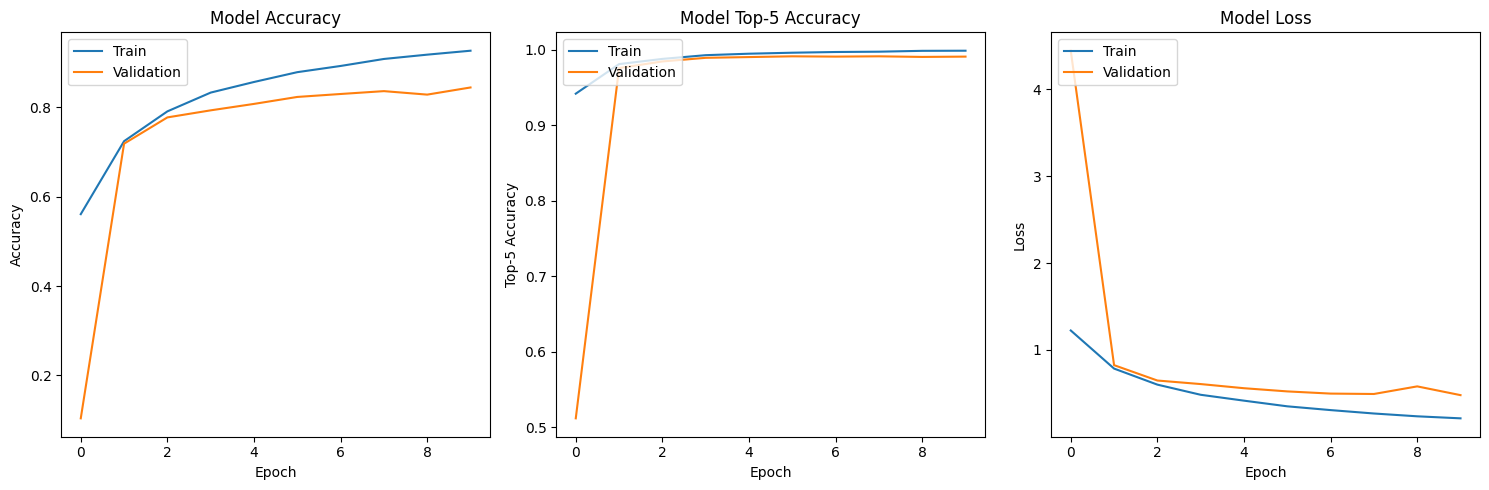

In [11]:
import matplotlib.pyplot as plt

def plot_history(history):
    # summarize history for accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # summarize history for top-5 accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['top-5-accuracy'])
    plt.plot(history.history['val_top-5-accuracy'])
    plt.title('Model Top-5 Accuracy')
    plt.ylabel('Top-5 Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()
plot_history(history)

# Visualizing the internals of ConvMixer

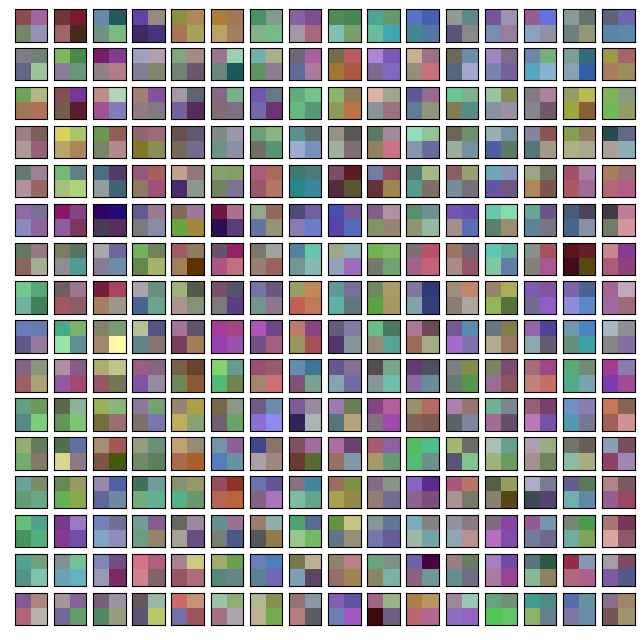

In [12]:
# Code reference: https://bit.ly/3awIRbP.


def visualization_plot(weights, idx=1):
    # First, apply min-max normalization to the
    # given weights to avoid isotrophic scaling.
    p_min, p_max = weights.min(), weights.max()
    weights = (weights - p_min) / (p_max - p_min)

    # Visualize all the filters.
    num_filters = 256
    plt.figure(figsize=(8, 8))

    for i in range(num_filters):
        current_weight = weights[:, :, :, i]
        if current_weight.shape[-1] == 1:
            current_weight = current_weight.squeeze()
        ax = plt.subplot(16, 16, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(current_weight)
        idx += 1


# We first visualize the learned patch embeddings.
patch_embeddings = conv_mixer_model.layers[2].get_weights()[0]
visualization_plot(patch_embeddings)

5 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7faac49416f0>
12 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7faac4219d20>
19 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7faac4a4aec0>
26 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7faac4941e40>
33 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7faac423d7b0>
40 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7faac423d660>
47 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7faac4272cb0>
54 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7faac4271ea0>


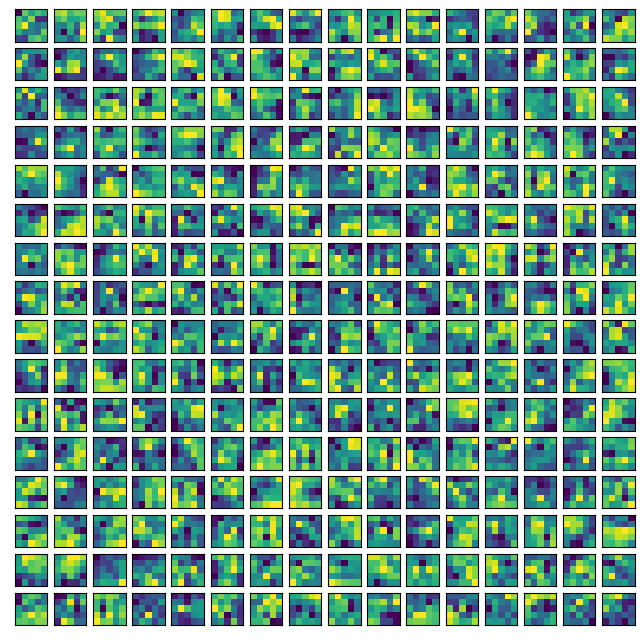

In [13]:
# First, print the indices of the convolution layers that are not
# pointwise convolutions.
for i, layer in enumerate(conv_mixer_model.layers):
    if isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        if layer.get_config()["kernel_size"] == (5, 5):
            print(i, layer)

idx = 26  # Taking a kernel from the middle of the network.

kernel = conv_mixer_model.layers[idx].get_weights()[0]
kernel = np.expand_dims(kernel.squeeze(), axis=2)
visualization_plot(kernel)

In [14]:
# Visualization X_test
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

1/1 [==============================] - 0s 53ms/step


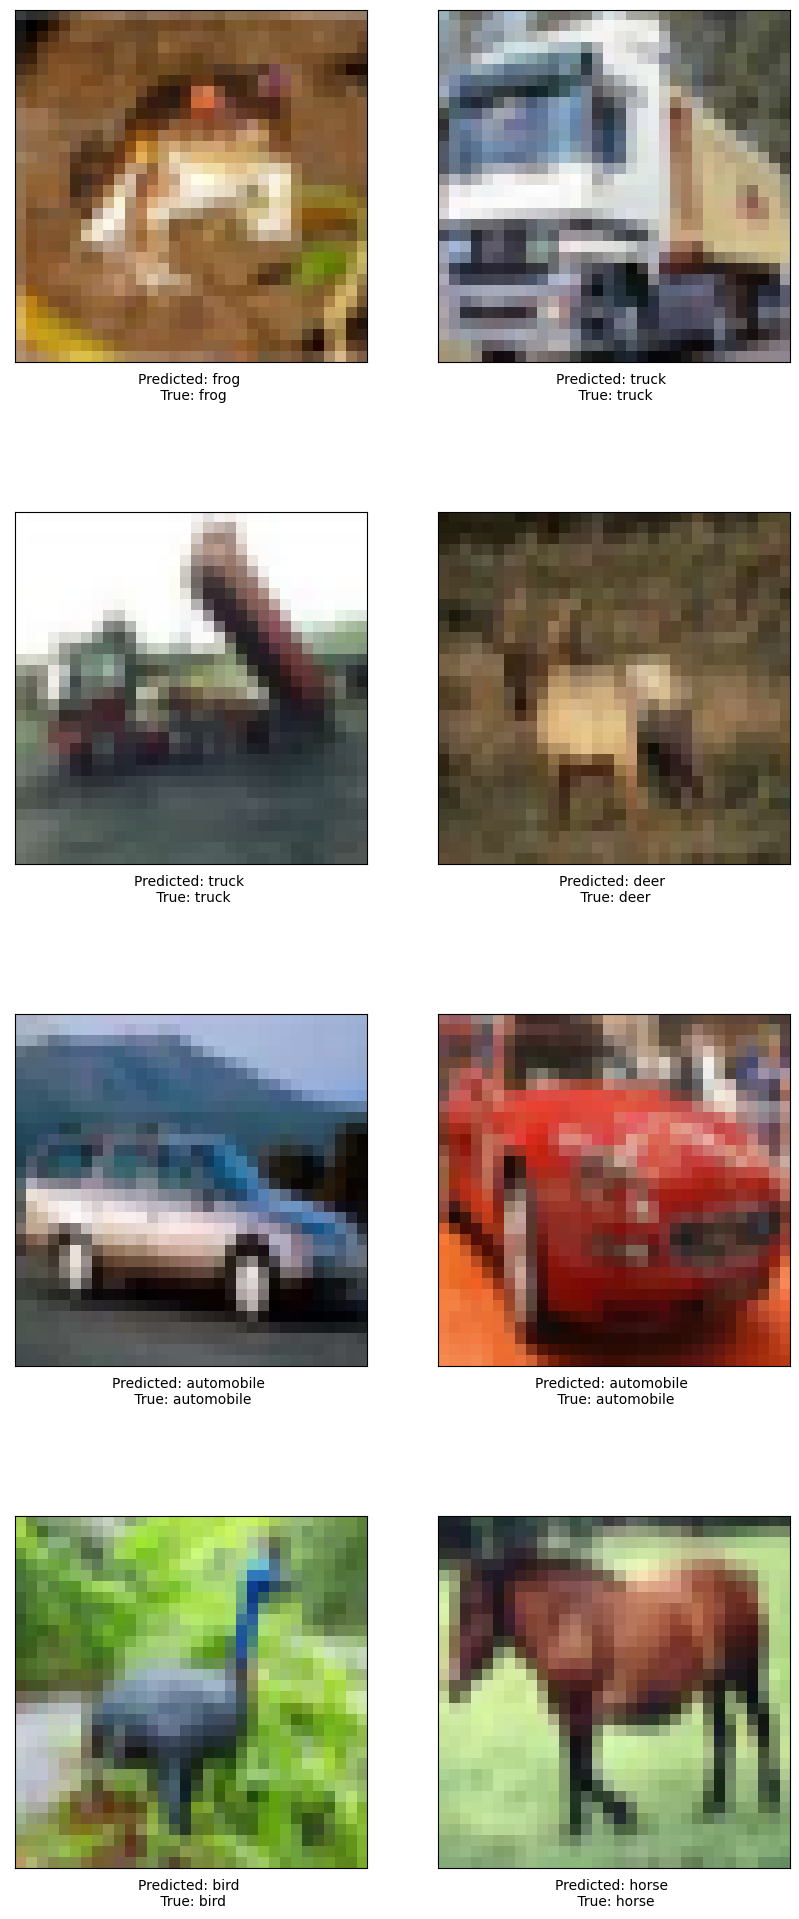

In [15]:
val_images, val_labels = next(iter(val_dataset))
val_labels = val_labels.numpy()  # Convert the labels to numpy array once

plt.figure(figsize=(10,25))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(val_images[i], cmap=plt.cm.binary)

    pred = history.model.predict(val_images[i:i+1])
    pred_label = np.argmax(pred)

    true_label = int((val_labels[i]))

    plt.xlabel(f"Predicted: {class_names[pred_label]} \n True: {class_names[true_label]}")
plt.show()
